In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
from helpers import load_csv_data
from helpers import create_csv_submission

# load dataset
y_train, tx_train, ids_train = load_csv_data("train.csv")
# y_test, tx_test, ids_test = load_csv_data("test.csv")

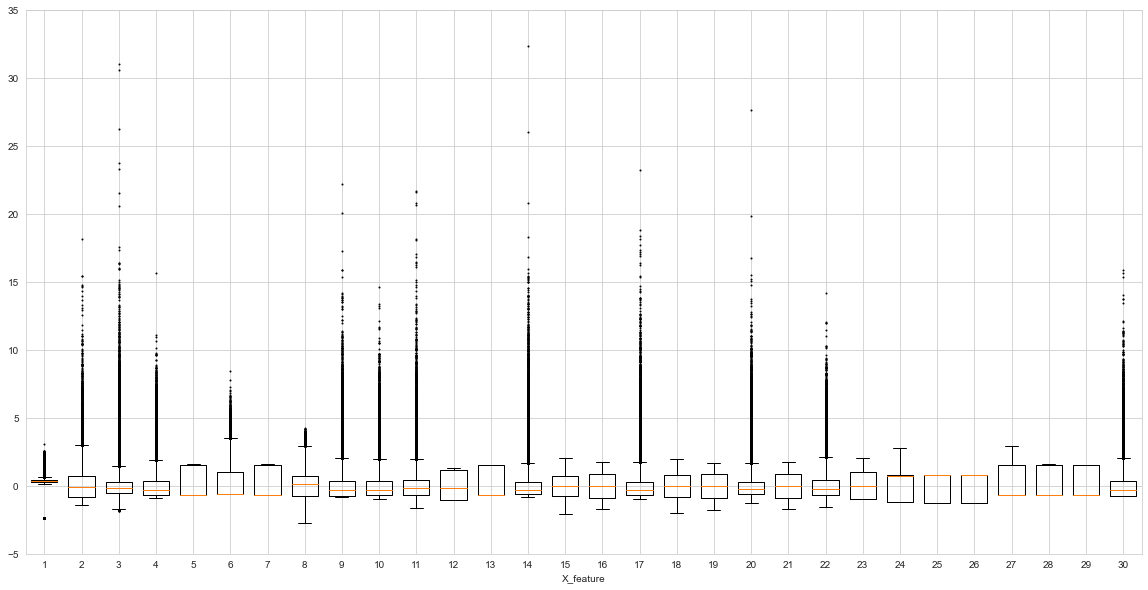

In [39]:
# raw data visualization to get a sense of it
# boxplot to help find outliers

box_tx_train = (tx_train - np.mean(tx_train,axis=0)) / np.std(tx_train,axis=0)

plt.figure(figsize=(20,10))
plt.rcParams['boxplot.flierprops.markersize'] = 1
plt.boxplot(box_tx_train,widths = 0.7)
plt.ylim(-5, 35)
plt.xlabel('X_feature')
plt.show()

Text(0.5, 1.0, 'Correlation Matrix of Raw Features')

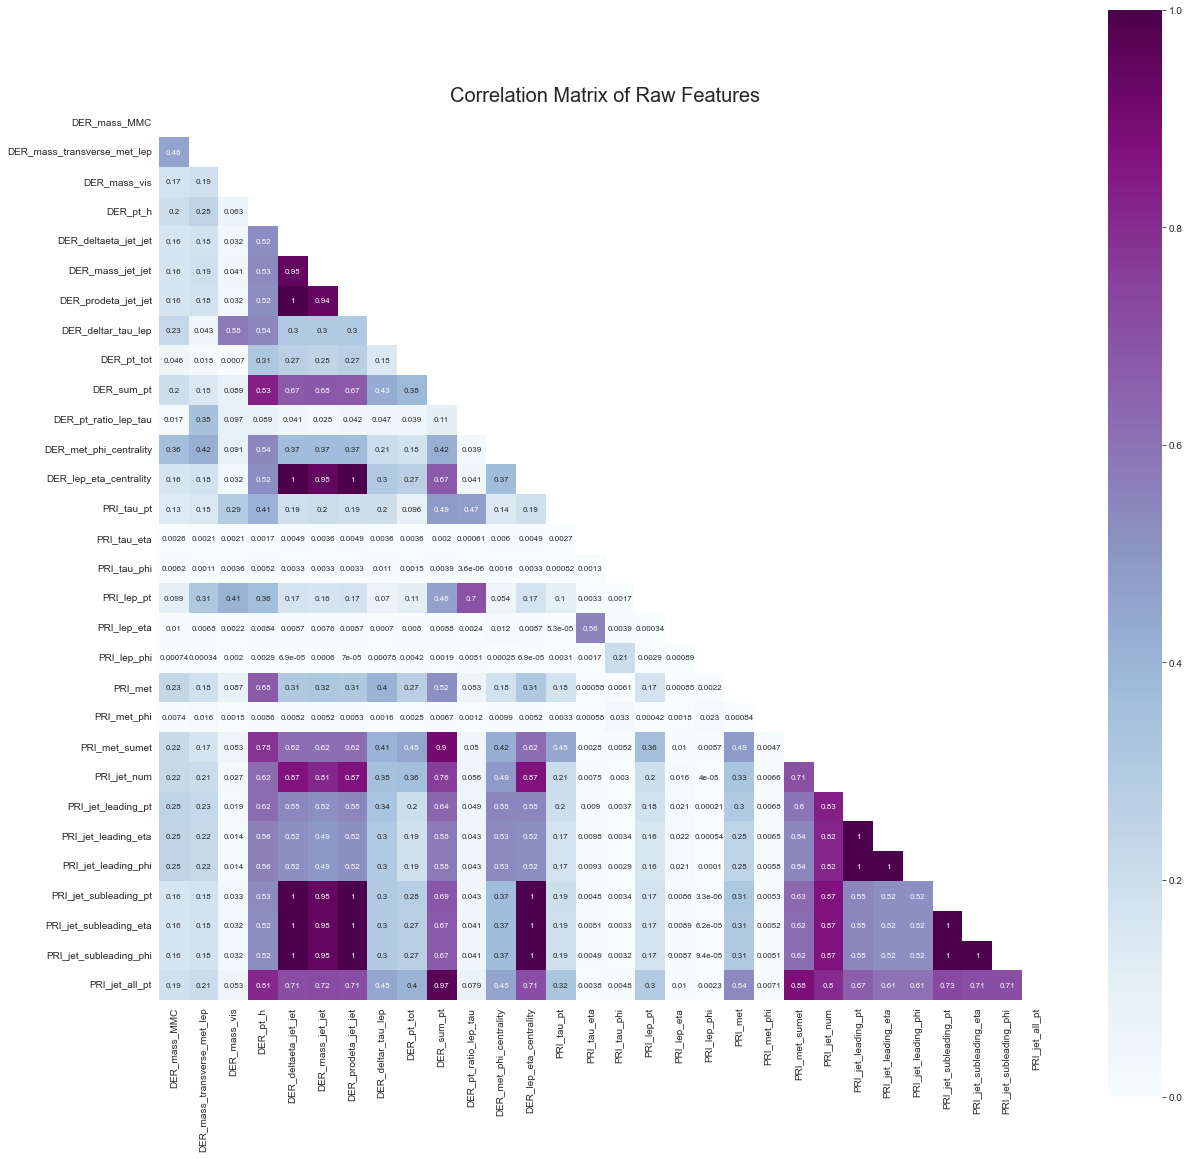

In [41]:
#

head = np.genfromtxt("train.csv", delimiter=",", dtype=str, max_rows=1)
head = head[2:32]
corr = np.corrcoef(tx_train.T)

mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot()
sns.heatmap(np.abs(corr), ax=ax, cmap="BuPu",mask = mask, square=True, fmt='.2g',\
            xticklabels=head, yticklabels=head, vmax=1, vmin=0 , annot=True, annot_kws={'size':8})
plt.title("Correlation Matrix of Raw Features", fontsize = 20)


In [100]:
def build_k_indices(num, k, seed):
    """build k indices for k-fold.  
    Args:
        y:      shape=(N,)
        k: K in K-fold, i.e. the fold num
        seed:   the random seed
    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold
    """
    interval = int(num / k)
    np.random.seed(seed)
    indices = np.random.permutation(num)
    k_indices = [indices[i * interval: (i + 1) * interval] for i in range(k)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k):
    """Split the train dataset to train and validation dataset with respect to k-fold cross validation."""
    y_test = np.array([])
    x_test = []
    for i in k_indices[k]:
        y_test = np.append(y_test, y[i])
        x_test.append(x[i])
    k_indices = np.delete(k_indices, k, axis=0)
    k_indices = k_indices.ravel()
    y_train = np.array([])
    x_train = []
    for i in k_indices:  
        y_train = np.append(y_train, y[i])
        x_train.append(x[i])
    return np.array(x_train), np.array(x_test), y_train.reshape(-1, 1), y_test

def _accuracy(Y_pred, Y_true):
    # This function calculates prediction accuracy
    # acc = 1 - np.mean(np.abs(Y_pred - Y_true))
    acc = sum(Y_true == Y_pred) / len(Y_true)
    return acc

def _precision(Y_pred, Y_true):
    prec = Y_pred.T.dot(Y_true.reshape(len(Y_true)))/(Y_pred.sum())
    # TP = np.sum(np.logical_and(np.equal(Y_true,1),np.equal(Y_pred,1)))
    # FP = np.sum(np.logical_and(np.equal(Y_true,0),np.equal(Y_pred,1)))
    # prec = TP / (TP + FP)
    return prec

Loss with Ridge Regression:  0.08488576564373886
Loss with Ridge Regression:  0.08497523968100755
Loss with Ridge Regression:  0.08510446843076519
Loss with Ridge Regression:  0.08507387276283389
Loss with Ridge Regression:  0.0851978807820349
Loss with Ridge Regression:  0.08488576574924138
Loss with Ridge Regression:  0.08497523968808793
Loss with Ridge Regression:  0.08510446843457802
Loss with Ridge Regression:  0.08507387287381624
Loss with Ridge Regression:  0.08519788091360764
Loss with Ridge Regression:  0.08488576796427659
Loss with Ridge Regression:  0.08497523983724593
Loss with Ridge Regression:  0.08510446851504215
Loss with Ridge Regression:  0.08507387519463593
Loss with Ridge Regression:  0.08519788368501599
Loss with Ridge Regression:  0.08488580167979948
Loss with Ridge Regression:  0.0849752421137317
Loss with Ridge Regression:  0.08510446974431586
Loss with Ridge Regression:  0.0850739105967375
Loss with Ridge Regression:  0.08519792594494296
Loss with Ridge Regress

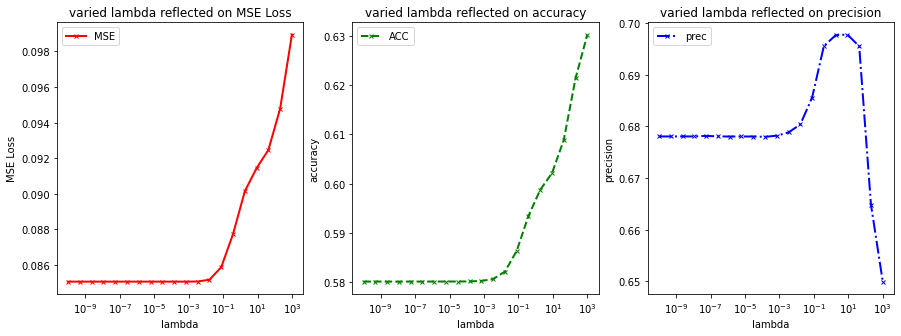

In [101]:
y_train[y_train == -1] = 0

y_train = y_train.reshape(len(y_train),1)
tx_train = tx_train

num = y_train.shape[0]
seed = 123
k_fold = 5
k_indices = build_k_indices(num, k_fold, seed)

def ridge_plot(mse_rr, acc_rr, prec_rr, lambdas):
    
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    
    ax[0].semilogx(lambdas, mse_rr, label="MSE", color='r', marker='x', markersize = 4, linestyle='solid', linewidth=2)
    ax[0].set_xlabel("lambda")
    ax[0].set_ylabel("MSE Loss")
    ax[0].legend(loc=0)
    ax[0].set_title("varied lambda reflected on MSE Loss")

    ax[1].semilogx(lambdas, acc_rr, label="ACC", color='g', marker='x', markersize = 4, linestyle='--', linewidth=2)
    ax[1].set_xlabel("lambda")
    ax[1].set_ylabel("accuracy")
    ax[1].legend(loc=0)
    ax[1].set_title("varied lambda reflected on accuracy")
    
    ax[2].semilogx(lambdas, prec_rr, label="prec", color='b', marker='x', markersize = 4, linestyle='-.', linewidth=2)
    ax[2].set_xlabel("lambda")
    ax[2].set_ylabel("precision")
    ax[2].legend(loc=0)
    ax[2].set_title("varied lambda reflected on precision")

    
    plt.show()
    
def ridge_regression_loop(y_train, tx_train, k_indices, k_fold):
    """loop to find best lambda"""
    lambdas = np.logspace(-10, 3, 20)
    mse_rr = []
    acc_rr = []
    prec_rr = []
    # ridge regression with different lambda
    for idx, lam in enumerate(lambdas):
        losses_temp = []
        accs_temp = []
        prec_temp = []
        for k in range(k_fold):
            x_tr, x_val, y_tr, y_val = cross_validation(y_train, tx_train, k_indices, k)
            w, loss = ridge_regression(y_tr, x_tr, lam)
            y_pred = predict_labels(w, x_val)
            acc = _accuracy(y_pred, y_val)
            prec = _precision(y_pred, y_val)
            accs_temp.append(acc)
            losses_temp.append(loss)
            prec_temp.append(prec)
        mse_rr.append(np.mean(losses_temp))
        acc_rr.append(np.mean(accs_temp))
        prec_rr.append(np.mean(prec_temp))
        # print("Average test prediction accuracy over " + str(k_fold) + " folds is " + str(np.mean(accs_temp)))


    ridge_plot(mse_rr, acc_rr, prec_rr, lambdas)
    
ridge_regression_loop(y_train, tx_train, k_indices, k_fold)

In [104]:
lambdas = np.logspace(-10, 3, 20)
lambdas

array([1.00000000e-10, 4.83293024e-10, 2.33572147e-09, 1.12883789e-08,
       5.45559478e-08, 2.63665090e-07, 1.27427499e-06, 6.15848211e-06,
       2.97635144e-05, 1.43844989e-04, 6.95192796e-04, 3.35981829e-03,
       1.62377674e-02, 7.84759970e-02, 3.79269019e-01, 1.83298071e+00,
       8.85866790e+00, 4.28133240e+01, 2.06913808e+02, 1.00000000e+03])